# Housing Prices: Voting Ensemble Regressor Approach

**Date:** 2025-10-30<br>
**Author:** *Luis Renteria Lezano*
## Executive Summary
- **Goal:** Build, evaluate, and compare regression models to accurately predict house sale prices using the cleaned and engineered dataset from the previous EDA stage [`/01_eda_and_feature_engineering.ipynb`](./01_eda_and_feature_engineering.ipynb).
- **Source:** This analysis uses the Housing Prices dataset from the Kaggle prediction competition [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/competitions/home-data-for-ml-course/overview)
- **Data:** [`../data/interim/features_cleaned.csv`](../data/interim/features_cleaned.csv).
- **Scope:** This notebook focuses on baseline models, ensemble methods, and performance evaluation using cross-validation and test predictions.

## 0. Reproducibility & Environment Setup
- Pin versions in [`../requirements.txt`](../).
- Keep raw data immutable [`../data/raw/`](../data/raw/).
- Export model outputs (metrics, predictions, feature importance) tables to [`../reports/tables/`](../reports/tables/) and figures to [`../reports/figures/voting`](../reports/figures/voting).

In [130]:
#  Imports & basic setup
import os
import sys
import joblib
from time import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Load Script
sys.path.append('../src')
from build_features import build_features

# Paths
DATA_RAW = Path('../data/raw')
DATA_INTERIM = Path('../data/interim')
DATA_PROCESSED = Path('../data/processed/voting')
REPORTS_TABLES = Path('../reports/tables')
REPORTS_FIGURES = Path('../reports/figures/voting')
MODELS = Path('../models')

# Create directories if missing
for folder in [DATA_RAW, DATA_INTERIM, DATA_PROCESSED, REPORTS_TABLES, REPORTS_FIGURES, MODELS]:
    folder.mkdir(parents=True, exist_ok=True)

# Plot themes and palettes defaults
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.facecolor'] = '#fafafa'
plt.rcParams['grid.alpha'] = 0.3
sns.set_theme(style='whitegrid', palette='colorblind', context='notebook')

print('Folder statuses:')
for d in [DATA_RAW, DATA_INTERIM, DATA_PROCESSED, REPORTS_TABLES, REPORTS_FIGURES]:
    print('\t', d.resolve(), '- Ready' if d.exists() else '- Missing')
print('> Environment setup completed.')

Folder statuses:
	 C:\Users\Usuario\Desktop\github-repos\house-prices-prediction\data\raw - Ready
	 C:\Users\Usuario\Desktop\github-repos\house-prices-prediction\data\interim - Ready
	 C:\Users\Usuario\Desktop\github-repos\house-prices-prediction\data\processed\voting - Ready
	 C:\Users\Usuario\Desktop\github-repos\house-prices-prediction\reports\tables - Ready
	 C:\Users\Usuario\Desktop\github-repos\house-prices-prediction\reports\figures\voting - Ready
> Environment setup completed.


## 1. Introduction

This notebook focuses on training and evaluating machine learning models to predict house sale prices using the processed Ames Housing dataset.
The data was cleaned and engineered in the previous notebook, ensuring consistent and ready-to-model inputs: [`../data/interim/features_cleaned.csv`](../data/interim/features_cleaned.csv)

**Purposes of this Notebook**

1. Build and compare baseline and ensemble regression models.
2. Evaluate model performance using cross-validation (RMSE, R²).
3. Generate final predictions for the Kaggle test set.

## 2. Load Processed Data & Overview

In [10]:
columns_available = pd.read_csv(REPORTS_TABLES / 'feature_descriptions.csv')
columns_available

,Feature,Type,Origin,Description
0,MSZoning,object,raw/encoded,Zoning type
1,Neighborhood,object,raw/encoded,Neighborhood area
2,HouseStyle,object,raw/encoded,House style
3,Exterior1st,object,raw/encoded,Exterior material
4,Foundation,object,raw/encoded,Foundation type
5,BsmtExposure,object,raw/encoded,Basement exposure type
6,GarageType,object,raw/encoded,Garage location
7,GarageFinish,object,raw/encoded,Garage finish
8,MoSold_cat,object,engineered,Month sold (Jan–Dec)
9,MSSubClass,int64,raw/encoded,Type of house sold


In [11]:
df = pd.read_csv(DATA_INTERIM / 'features_cleaned.csv')
df.head(3)

,MSZoning,Neighborhood,HouseStyle,Exterior1st,Foundation,BsmtExposure,GarageType,GarageFinish,MoSold_cat,MSSubClass,...,Age,PorchSF,ComponentsQual,HasBsmt,HasGarage,Has2ndFloor,HasPool,Remodeled,SalePrice,SalePrice_log
0,RL,CollgCr,2Story,VinylSd,PConc,No,Attchd,RFn,Feb,60,...,5,61,3.625,1,1,1,0,0,208500,12.247699
1,RL,Veenker,1Story,MetalSd,CBlock,Gd,Attchd,RFn,May,20,...,31,0,3.375,1,1,0,0,0,181500,12.109016
2,RL,CollgCr,2Story,VinylSd,PConc,Mn,Attchd,RFn,Sep,60,...,7,42,3.625,1,1,1,0,1,223500,12.317171


In [12]:
X = df.drop(['SalePrice', 'SalePrice_log'], axis=1)
y = df['SalePrice_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

X_train.to_csv(DATA_PROCESSED / 'X_train.csv', index=False)
X_test.to_csv(DATA_PROCESSED / 'X_test.csv', index=False)
y_test.to_csv(DATA_PROCESSED / 'y_train.csv', index=False)
y_test.to_csv(DATA_PROCESSED / 'y_test.csv', index=False)

print('Train and Test sets saved.')
print(f'''> Training set has: {X_train.shape[0]} samples
> Test set has: {X_test.shape[0]} samples
> # of features: {len(X_test.columns)}''')

Train and Test sets saved.
> Training set has: 1093 samples
> Test set has: 365 samples
> # of features: 30


## 3. Preprocesssing  
Ordinal features were already encoded during feature engineering in the previous notebook and the function retrieved in `../src/build_features.py`. Therefore, in this preprocessing pipeline, only imputation, scaling & log transformation (since we will use linear models), and one-hot encoding (OHE) will be applied.

In [13]:
num_cols = X_train.select_dtypes(['number', 'int64', 'float64', 'bool']).columns
cat_cols = X_train.select_dtypes(['object', 'string']).columns

print(f'Numerical Features ({len(num_cols)}): {num_cols.tolist()}\n')
print(f'Categorical Features ({len(cat_cols)}): {cat_cols.tolist()}')

Numerical Features (21): ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'BsmtFinType1_ord', 'TotalSF', 'TotalBathrooms', 'Age', 'PorchSF', 'ComponentsQual', 'HasBsmt', 'HasGarage', 'Has2ndFloor', 'HasPool', 'Remodeled']

Categorical Features (9): ['MSZoning', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'Foundation', 'BsmtExposure', 'GarageType', 'GarageFinish', 'MoSold_cat']


In [14]:
from scipy.stats import skew
skew_vals = df[num_cols].drop(['HasBsmt','HasGarage','Has2ndFloor','HasPool','Remodeled'], axis=1).skew().sort_values(ascending=False)
skew_vals

LotArea             12.573925
MasVnrArea           2.687784
PorchSF              2.011471
WoodDeckSF           1.545805
MSSubClass           1.407011
TotalSF              0.844596
BsmtFinSF1           0.764789
OverallCond          0.691035
TotRmsAbvGrd         0.660502
Fireplaces           0.632060
Age                  0.607894
TotalBathrooms       0.213725
OverallQual          0.200786
GarageCars          -0.342377
ComponentsQual      -1.065652
BsmtFinType1_ord    -1.121893
dtype: float64

In [15]:
# Numerical Pipeline
num_pipeline_log = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transf', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Compose transformations
ct = ColumnTransformer([
    ('num_log', num_pipeline_log, skew_vals[np.abs(skew_vals) > 1].index.tolist()),
    ('num', num_pipeline, skew_vals[np.abs(skew_vals) <= 1].index.tolist()),
    ('cat', cat_pipeline, cat_cols)
])

## 4. Model Building and Hyperparameter Tuning

In [16]:
models = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': np.logspace(-1, 0.3, 8),  # regularization strength
            'model__solver': ['auto']  # optimization algorithm
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'model__alpha': np.logspace(-4, -3, 5)  # constant that multiplies the L1 term
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=SEED),
        'params': {
            'model__n_estimators': [200, 300, 500],  # number of trees
            'model__max_depth': [10, 20],  # max depth per tree
            'model__min_samples_split': [5],  # min samples per split
            'model__min_samples_leaf': [1, 2],  # min leaves per node
            'model__max_features': ['sqrt']  # number of features per split/ none uses all
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=SEED),
        'params': {
            'model__n_estimators': [700, 800, 900],  
            'model__learning_rate': [0.020, 0.024, 0.028, 0.032],  # modifies how big the step is in the gradient direction
            'model__max_depth': [3],
            'model__subsample': [0.8],  # % of samples to use randomly
            'model__min_samples_split': [5, 10],  
            'model__min_samples_leaf': [2, 3, 4],
            'model__max_features': ['sqrt', None]
        }
    },
    'SVM': {
    'model': SVR(),
    'params': {
        'model__kernel': ['rbf'],
        'model__C': [5, 10, 20, 40],
        'model__gamma': [0.0005, 0.001, 0.002, 0.004],
        'model__epsilon': [0.08, 0.10, 0.12],
        }
    },
}

In [17]:
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
best_models_parameters = {}
all_cv_results = []  # to export .csv with all the results

print('Training process started!\n')
for model_name, model_config in models.items():

    print(f'Training {model_name}...')
    time_start = time()

    preprocessed_model = Pipeline([
        ('preprocessing_ct', ct),
        ('model', model_config['model'])
    ])
    
    # cv = RandomizedSearchCV(preprocessed_model, model_config['params'], cv=kf, n_iter=10, n_jobs=-1, scoring='neg_root_mean_squared_error')
    cv = GridSearchCV(preprocessed_model, model_config['params'], cv=kf, n_jobs=-1, scoring='neg_root_mean_squared_error')
    cv.fit(X_train, y_train)

    # Workflow to save all gridsearch together in a single CSV file
    model_cv_df = pd.DataFrame(cv.cv_results_)
    model_cv_df['Model'] = model_name
    all_cv_results.append(model_cv_df)
    
    best_models_parameters[model_name] = {}
    best_models_parameters[model_name]['Best Estimator'] = cv.best_estimator_
    best_models_parameters[model_name]['Best Params'] = cv.best_params_
    best_models_parameters[model_name]['Best Score'] = cv.best_score_

    time_stop = time()
    
    print(f'> It took {time_stop-time_start:.2f} seconds to train {model_name} model.\nBest RMSE: {-1*cv.best_score_:.2f}.\n')

Training process started!

Training Ridge...
> It took 5.87 seconds to train Ridge model.
Best RMSE: 0.12.

Training Lasso...
> It took 0.34 seconds to train Lasso model.
Best RMSE: 0.12.

Training Random Forest...
> It took 13.57 seconds to train Random Forest model.
Best RMSE: 0.14.

Training Gradient Boosting...
> It took 322.73 seconds to train Gradient Boosting model.
Best RMSE: 0.12.

Training SVM...
> It took 5.36 seconds to train SVM model.
Best RMSE: 0.11.



In [18]:
full_cv_results_df = pd.concat(all_cv_results, ignore_index=True)

clean_summary = []
for model, info in best_models_parameters.items():
    # getting rid of model__ prefix
    clean_params = {k.replace('model__', ''): v for k, v in info['Best Params'].items()}
    clean_summary.append({
        "Model": model,
        "Best Params": clean_params
    })
    
summary = pd.DataFrame(clean_summary)
# Show Results
pd.set_option('display.max_colwidth', None)
display(summary)

,Model,Best Params
0,Ridge,"{'alpha': 1.9952623149688795, 'solver': 'auto'}"
1,Lasso,{'alpha': 0.0005623413251903491}
2,Random Forest,"{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}"
3,Gradient Boosting,"{'learning_rate': 0.024, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 900, 'subsample': 0.8}"
4,SVM,"{'C': 20, 'epsilon': 0.08, 'gamma': 0.001, 'kernel': 'rbf'}"


In [19]:
# Export results in a table
summary.to_csv(REPORTS_TABLES / 'best_models_voting.csv', index=False)
full_cv_results_df.to_csv(REPORTS_TABLES / 'cv_results_voting.csv', index=False)

print("Best Models summary saved in reports directory.")
print("Cross-Validation results saved in reports directory.")

Best Models summary saved in reports directory.
Cross-Validation results saved in reports directory.


## 5. Model Evaluation

In [20]:
estimators = []
for key, value in best_models_parameters.items():
    estimator = (key, value['Best Estimator'])
    estimators.append(estimator)

voting_reg = VotingRegressor(estimators=estimators, n_jobs=-1)

In [21]:
# Evaluation of the voting model, using cross-validation for a more accurate result on the train score
cv_scores = cross_val_score(voting_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)

# Evaluate on the test set
voting_reg.fit(X_train, y_train)
y_pred = voting_reg.predict(X_test)

print(f'Average Accuracy of the Ensemble in train: {-1*cv_scores.mean():.4f}')
print(f'Test Final Accuracy: {root_mean_squared_error(y_test, y_pred):.4f}')

Average Accuracy of the Ensemble in train: 0.1136
Test Final Accuracy: 0.1138


In [22]:
cv_mean = -cv_scores.mean()  # to positive
test_rmse = root_mean_squared_error(y_test, y_pred)
diff_pct = abs(test_rmse - cv_mean) / cv_mean * 100
print(f'The difference between the average cross-validation score on the training set and the holdout test score is minimal, approximately {diff_pct:.2f}%, indicating strong generalization performance.')

The difference between the average cross-validation score on the training set and the holdout test score is minimal, approximately 0.18%, indicating strong generalization performance.


In [131]:
# Interpretable version, since we are using log, we will need to do the inverse:
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

# Compute RMSE in dollars
rmse_real = root_mean_squared_error(y_test_exp, y_pred_exp)
r2_real = r2_score(y_test_exp, y_pred_exp)
print(f"RMSE in SalePrice (dollars): {rmse_real:.3f}")
print(f"R2 in SalePrice: {r2_real*100:.2f}%")

RMSE in SalePrice (dollars): 20340.987
R2 in SalePrice: 93.25%


## 6. Model Comparison

In [122]:
estimators_results = {}
estimators_scores = []

for i, model in enumerate(best_models_parameters):
    estimator = best_models_parameters[model]['Best Estimator']
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    estimators_results[model] = y_pred.copy()
    estimators_scores.append((root_mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)))

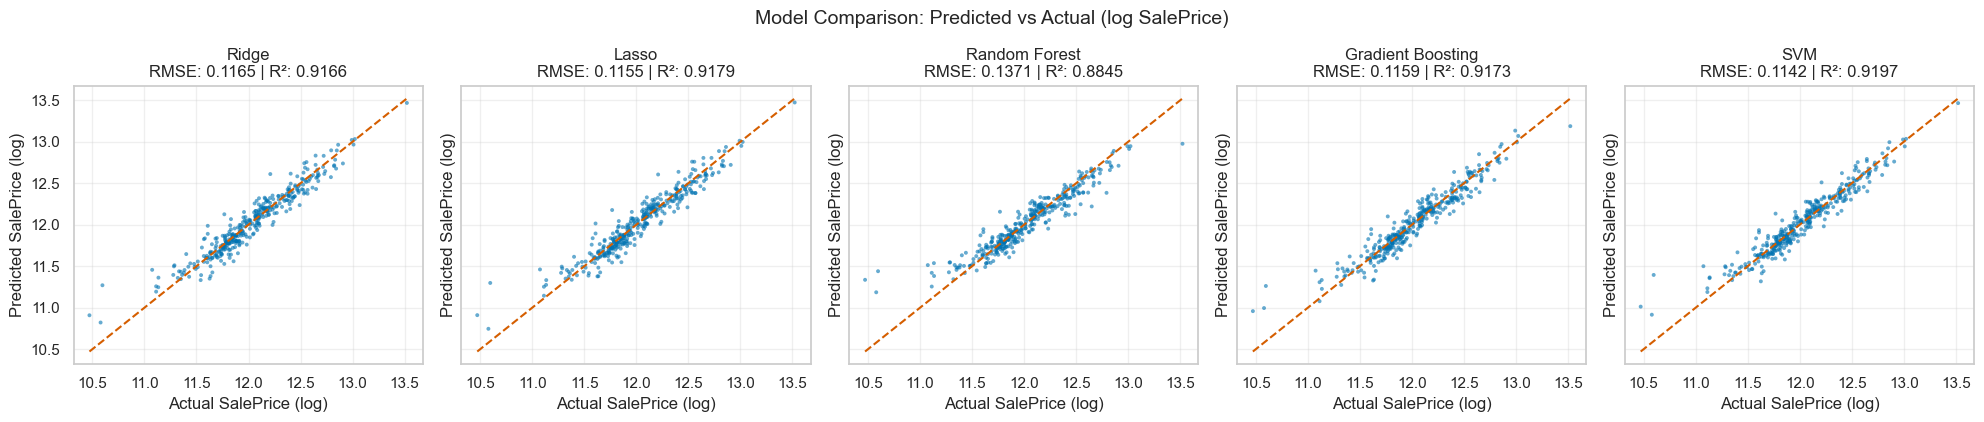

In [123]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for ax, (name, preds, scores) in zip(axes, zip(estimators_results.keys(), estimators_results.values(), estimators_scores)):
    ax.scatter(y_test, preds, alpha=0.6, edgecolor='none', s=8)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_title(f'{name}\nRMSE: {scores[0]:.4f} | R²: {scores[1]:.4f}')
    ax.set_xlabel('Actual SalePrice (log)')
    ax.set_ylabel('Predicted SalePrice (log)')

plt.tight_layout()
fig.suptitle('Model Comparison: Predicted vs Actual (log SalePrice)', fontsize=14, y=1.05)
plt.savefig(REPORTS_FIGURES / '01_pred_vs_actual_models.png', dpi=150, bbox_inches='tight')
plt.show()

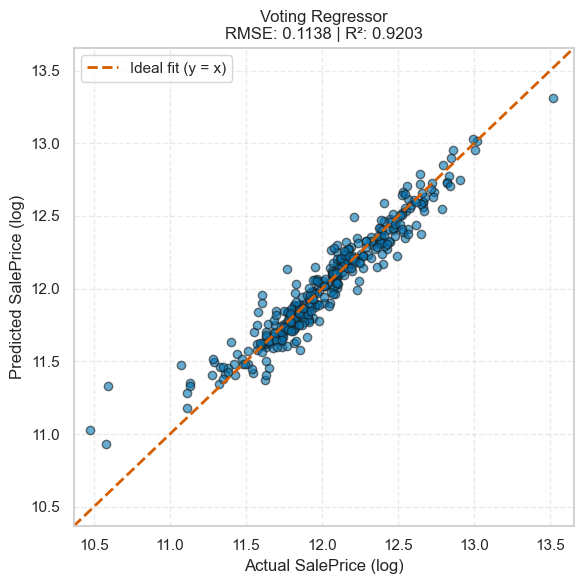

In [124]:
voting_reg.fit(X_train, y_train)
y_pred = voting_reg.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
x_min, x_max = y_test.min()*0.99, y_test.max()*1.01
plt.plot([x_min, x_max], [x_min, x_max], 'r--', lw=2, label='Ideal fit (y = x)')


plt.title(f'Voting Regressor\nRMSE: {rmse:.4f} | R²: {r2:.4f}')
plt.xlabel('Actual SalePrice (log)')
plt.ylabel('Predicted SalePrice (log)')

plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.grid(True, linestyle='--', alpha=0.4)

plt.legend()
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / '02_voting_regressor_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Error Interpretation

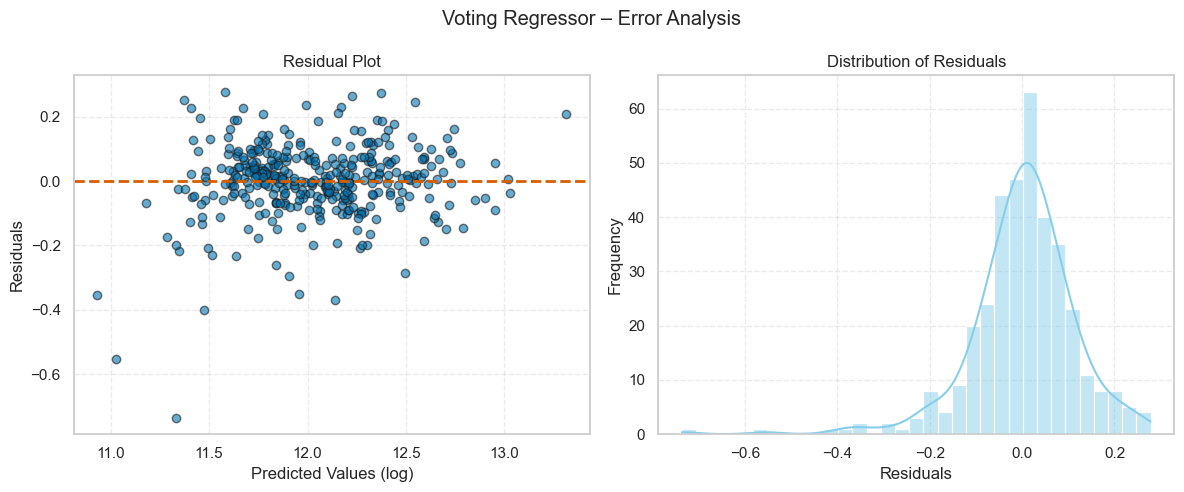

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residual Plot
axes[0].scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
axes[0].axhline(0, color='r', linestyle='--', lw=2)
axes[0].set_title('Residual Plot')
axes[0].set_xlabel('Predicted Values (log)')
axes[0].set_ylabel('Residuals')
axes[0].grid(True, linestyle='--', alpha=0.4)

# Distribution of Residuals
sns.histplot(residuals, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, linestyle='--', alpha=0.4)
plt.suptitle('Voting Regressor – Error Analysis')

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / '03_voting_regressor_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


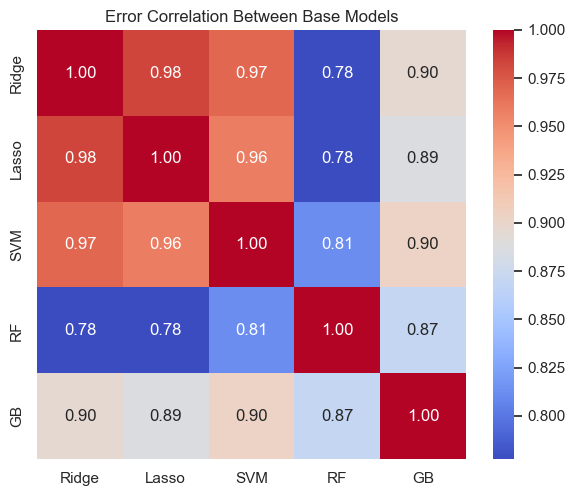

In [126]:
errors = pd.DataFrame({
    'Ridge': y_test - estimators_results['Ridge'],
    'Lasso': y_test - estimators_results['Lasso'],
    'SVM': y_test - estimators_results['SVM'],
    'RF': y_test - estimators_results['Random Forest'],
    'GB': y_test - estimators_results['Gradient Boosting']
})

plt.figure(figsize=(6,5))
sns.heatmap(errors.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Error Correlation Between Base Models')
plt.tight_layout()

plt.savefig(REPORTS_FIGURES / '04_base_models_error_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

**Key Findings:**  
1. The residuals are centered around zero and show no clear pattern, indicating that the model is well-fitted without systematic bias.
2. The residuals follow an approximately normal distribution, suggesting stable error variance and good generalization.
3. The error correlation heatmap shows Ridge, Lasso, and SVR behave similarly, while RF and GB add useful diversity to the ensemble.

## 8. Conclusion and Recommendations

In this notebook, many regression models were trained and combined using a Voting Regressor ensemble to predict house sale prices.  
Almost all data preprocessing and all feature engineering were previously completed in the [EDA notebook](./01_eda_and_feature_engineering.ipynb), allowing this stage to focus exclusively on model training and evaluation.

**Key Findings**  
- The ensemble achieved strong and consistent performance across cross-validation folds:  
  - **Average CV RMSE (train):** 0.1136  
  - **Test RMSE:** 0.1138  
  - **Difference:** only **0.18%**, indicating excellent generalization.  
- When converted back to the real price scale:  
  - **RMSE:** \$20,340.99  
  - **R²:** 93.25%  
- The ensemble effectively leveraged both linear and tree models, combining their strengths to minimize bias and variance.

**Technical Insights**  
- Since the pipeline included a `FunctionTransformer()` for numerical features, collection of feature importances is not possible in this notebook.  
- A dedicated notebook will be developed focusing exclusively on Gradient Boosting, trained without any transformations, to analyze and visualize feature importances more accurately.
- The log transformation, applied during EDA and preprocessing, contributed to stabilizing feature variance and making training more stable.

**Performance on Kaggle**  

As of **October 31, 2025**, this model achieved a Public Leaderboard $RMSE = 14227.24759$, **ranking #202** in the [Kaggle competition leaderboard](https://www.kaggle.com/competitions/home-data-for-ml-course/leaderboard).  
This confirms the robustness of the ensemble and the effectiveness of the preprocessing strategy designed in the EDA stage.

**Recommendations and Next Steps**  
- Develop a follow-up notebook focused on Gradient Boosting, to analyze feature importances and improve interpretability.  
- Explore hyperparameter optimization using `RandomizedSearchCV`.  
- Consider Stacking Regressors as an alternative to Voting for better ensemble control.

## 9. Exporting Model

**Export final model and results:**

In [25]:
print('Exporting results...')
joblib.dump(voting_reg, MODELS / 'voting_regressor.pkl')
print('Model saved to voting_regressor.pkl')

Exporting results...
Model saved to voting_regressor.pkl


**Create Submission CSV for Kaggle Competition:** 

This code prepares and exports predictions for the Housing Prices competition. It loads and preprocesses the test data and generates predictions using the previous trained ensemble model `voting_reg`, and saves the results as a CSV file ready for submission [here](https://www.kaggle.com/competitions/titanic/data).

In [26]:
X_competition_raw = pd.read_csv(DATA_RAW / 'test.csv')
X_competition = build_features(X_competition_raw)
y_competition_log = voting_reg.predict(X_competition)
y_competition = np.expm1(y_competition_log)

pd.DataFrame({'Id': pd.read_csv(DATA_RAW / 'test.csv')['Id'], 'SalePrice': y_competition}).to_csv(DATA_PROCESSED / 'submission.csv', index=False)
print('Competition submission.csv saved.')

Competition submission.csv saved.
